# Programming Project 4: Image-Based Lighting


## Recovering HDR Radiance Maps 

Load libraries and data

In [2]:
# jupyter extension that allows reloading functions from imports without clearing kernel :D
%load_ext autoreload
%autoreload 2

In [4]:
# System imports
from os import path
import math

# Third-Party Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# modify to where you store your project data including utils
datadir = "/content/drive/My Drive/cs445_projects/proj4/" 

utilfn = datadir + "utils"
!cp -r "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .

# can change this to your output directory of choice
!mkdir "images"
!mkdir "images/outputs"

# import starter code
import utils
from utils.io import read_image, write_image, read_hdr_image, write_hdr_image
from utils.display import display_images_linear_rescale, rescale_images_linear
from utils.hdr_helpers import gsolve
from utils.hdr_helpers import get_equirectangular_image
from utils.bilateral_filter import bilateral_filter



'cp' is not recognized as an internal or external command,
operable program or batch file.
'cp' is not recognized as an internal or external command,
operable program or batch file.
A subdirectory or file images already exists.
A subdirectory or file images/outputs already exists.


### Reading LDR images

You can use the provided samples or your own images.  You get more points for using your own images, but it might help to get things working first with the provided samples.

In [5]:

imdir = 'tommy'
imfns = ['25.jpeg', '60.jpeg', '125.jpeg', '200.jpeg', '500.jpeg']
exposure_times = [1/25.0, 1/60.0, 1/125.0, 1/200.0, 1/500.0]

ldr_images = []
for f in np.arange(len(imfns)):
  im = read_image(imdir + '/' + imfns[f])
  if f==0:
    imsize = int((im.shape[0] + im.shape[1])/2) # set width/height of ball images
    ldr_images = np.zeros((len(imfns), imsize, imsize, 3))
  ldr_images[f] = cv2.resize(im, (imsize, imsize))

background_image_file = imdir + '/' + 'empty.jpeg'
background_image = read_image(background_image_file)



(3024, 4032, 3)


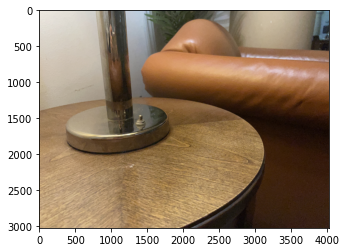

In [6]:
plt.figure("background")
plt.imshow(background_image)

print(background_image.shape)

In [25]:

simdir = 'samples'
simfns = ['0024.jpg', '0060.jpg', '0120.jpg', '0205.jpg', '0553.jpg']
sexposure_times = [1/24.0, 1/60.0, 1/120.0, 1/205.0, 1/553.0]

sldr_images = []
for f in np.arange(len(simfns)):
  im = read_image(simdir + '/' + simfns[f])
  if f==0:
    imsize = int((im.shape[0] + im.shape[1])/2) # set width/height of ball images
    sldr_images = np.zeros((len(simfns), imsize, imsize, 3))
  sldr_images[f] = cv2.resize(im, (imsize, imsize))

sbackground_image_file = simdir + '/' + 'empty.jpg'
sbackground_image = read_image(sbackground_image_file)

### Naive LDR merging 

Compute the HDR image as average of irradiance estimates from LDR images

In [26]:
def make_hdr_naive(ldr_images: np.ndarray, exposures: list) -> (np.ndarray, np.ndarray):
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    
    The steps to implement:
    1) Divide each image by its exposure time.
        - This will rescale images as if it has been exposed for 1 second.
    
    2) Return average of above images
    
    
    For further explanation, please refer to problem page for how to do it.
      
    Args:
        ldr_images(np.ndarray): N x H x W x 3  shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposures(list): list of length N, representing exposures of each images.
            Each exposure should correspond to LDR images' exposure value.
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged using
            naive ldr merging implementation.
        (np.ndarray): N x H x W x 3  shaped numpy array represending log irradiances
            for each exposures   
    '''
    N, H, W, C = ldr_images.shape
    # sanity check
    assert N == len(exposures)

    # ldr_images = ldr_images * 255
    irradiance = []
    for i in range(0, N):
        irradiance.append(ldr_images[i]/exposures[i])

    irradiance = np.array(irradiance)
    log_irradiances = np.log(irradiance)
    hdr_image = np.average(irradiance, axis = 0)

    return hdr_image, log_irradiances



In [27]:
def display_hdr_image(im_hdr):
    '''
    Maps the HDR intensities into a 0 to 1 range and then displays. 
    Three suggestions to try: 
      (1) Take log and then linearly map to 0 to 1 range (see display.py for example) 
      (2) img_out = im_hdr / (1 + im_hdr)
      (3) HDR display code in a python package 
    '''

    img = np.nan_to_num(im_hdr, 0)
    img = img.copy().astype(np.float32)

    tonemap1 = cv2.createTonemap(gamma=3)
    res_debvec = tonemap1.process(img)
    res_debvec_8bit = np.clip(res_debvec*255, 0, 255).astype('uint8')
    plt.figure()
    plt.imshow(res_debvec_8bit)
    # img_out = im_hdr/(1+im_hdr)
    
    # plt.figure()
    # plt.imshow(img_out)


C:\Users\ktomo\AppData\Local\Temp/ipykernel_4636/1456914726.py:35: RuntimeWarning: divide by zero encountered in log
  log_irradiances = np.log(irradiance)


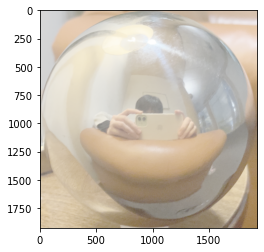

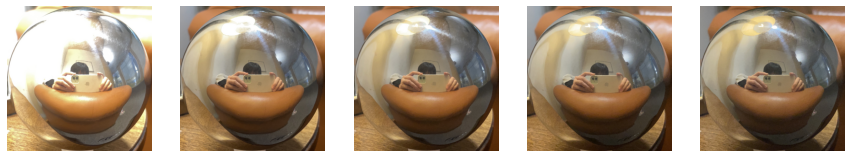

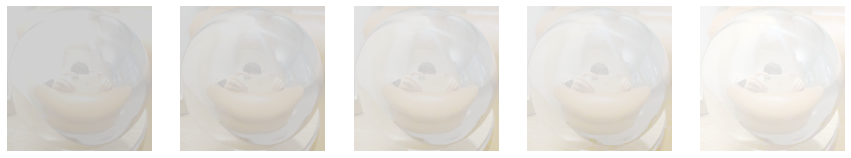

In [28]:

# get HDR image, log irradiance
naive_hdr_image, naive_log_irradiances = make_hdr_naive(ldr_images, exposure_times)

# write HDR image to directory
write_hdr_image(naive_hdr_image, 'images/outputs/naive_hdr.hdr')

# display HDR image
display_hdr_image(naive_hdr_image)

# display original images (code provided in utils.display)
display_images_linear_rescale(ldr_images)

# display log irradiance image (code provided in utils.display)
display_images_linear_rescale(naive_log_irradiances)


C:\Users\ktomo\AppData\Local\Temp/ipykernel_4636/1456914726.py:35: RuntimeWarning: divide by zero encountered in log
  log_irradiances = np.log(irradiance)


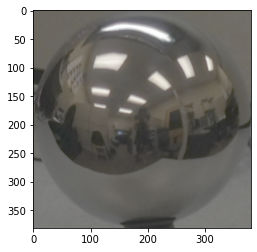

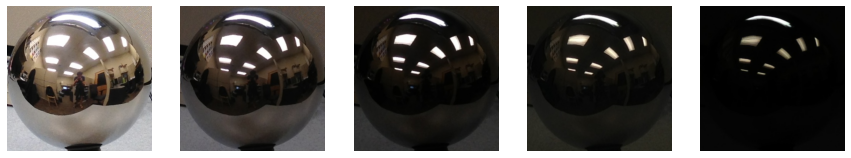

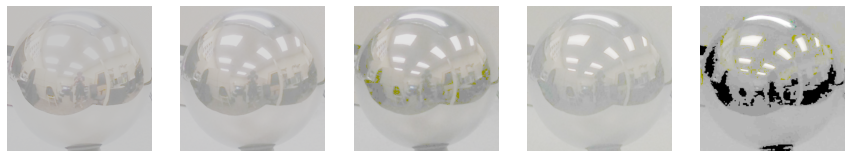

In [29]:
snaive_hdr_image, snaive_log_irradiances = make_hdr_naive(sldr_images, sexposure_times)

# write HDR image to directory
write_hdr_image(snaive_hdr_image, 'images/outputs/snaive_hdr.hdr')

# display HDR image
display_hdr_image(snaive_hdr_image)

# display original images (code provided in utils.display)
display_images_linear_rescale(sldr_images)

# display log irradiance image (code provided in utils.display)
display_images_linear_rescale(snaive_log_irradiances)


### Weighted LDR merging 

Compute HDR image as a weighted average of irradiance estimates from LDR images, where weight is based on pixel intensity so that very low/high intensities get less weight


In [30]:
def make_hdr_weighted(ldr_images: np.ndarray, exposure_times: list) -> (np.ndarray):
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    
    The steps to implement:
    1) compute weights for images with based on intensities for each exposures
        - This can be a binary mask to exclude low / high intensity values

    2) Divide each images by its exposure time.
        - This will rescale images as if it has been exposed for 1 second.
    
    3) Return weighted average of above images
    
    
    Args:
        ldr_images(np.ndarray): N x H x W x 3 shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposure_times(list): list of length N, representing exposures of each images.
            Each exposure should correspond to LDR images' exposure value.
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged without
            under - over exposed regions

    '''
    w = lambda z: 128 - np.abs(z - 128)
    
    N, H, W, C = ldr_images.shape
    # sanity check
    assert N == len(exposure_times)
    
    # # TODO: Implement ldr_images + exposure_times -> HDR image function here
    
    # ldr_images = ldr_images * 255
    weights = w(ldr_images*255)
    irradiance = []
    for i in range(0, N):
        irradiance.append(weights[i] * ldr_images[i]/exposure_times[i])

    irradiance = np.array(irradiance)
    log_irradiances = np.log((irradiance+0.01)/np.sum(weights, axis=0))
    hdr_image = np.sum(irradiance, axis = 0)/np.sum(weights, axis=0)
    
    return hdr_image

    # TO DO


Text(0.5, 1.0, 'Naive HDR Image')

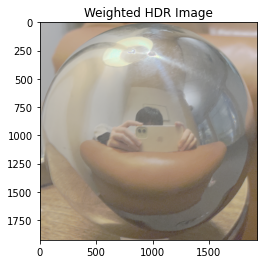

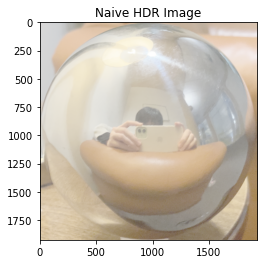

In [31]:
# get HDR image, log irradiance
weighted_hdr_image = make_hdr_weighted(ldr_images, exposure_times)

# write HDR image to directory
write_hdr_image(weighted_hdr_image, 'images/outputs/weighted_hdr.hdr')

# display HDR image
display_hdr_image(weighted_hdr_image)
plt.title("Weighted HDR Image")
display_hdr_image(naive_hdr_image)
plt.title("Naive HDR Image")


Text(0.5, 1.0, 'Naive HDR Image')

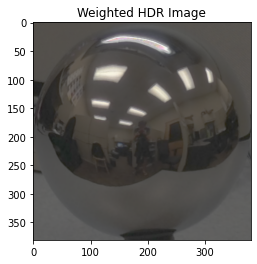

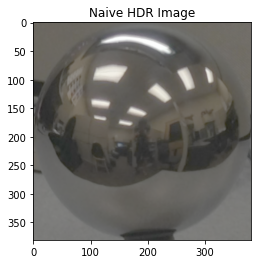

In [32]:
# get HDR image, log irradiance
sweighted_hdr_image = make_hdr_weighted(sldr_images, sexposure_times)

# write HDR image to directory
write_hdr_image(sweighted_hdr_image, 'images/outputs/sweighted_hdr.hdr')

# display HDR image
display_hdr_image(sweighted_hdr_image)
plt.title("Weighted HDR Image")
display_hdr_image(snaive_hdr_image)
plt.title("Naive HDR Image")

Display of difference between naive and weighted for your own inspection

Where does the weighting make a big difference increasing or decreasing the irradiance estimate?  Think about why.

Min ratio =  0.2614994069191945   Max ratio =  4.084060417834838


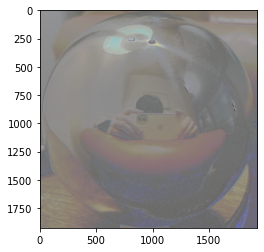

In [33]:
# display difference between naive and weighted 

log_diff_im = np.log(weighted_hdr_image)-np.log(naive_hdr_image)
print('Min ratio = ', np.exp(log_diff_im).min(), '  Max ratio = ', np.exp(log_diff_im).max())
plt.figure()
plt.imshow(rescale_images_linear(log_diff_im))

Min ratio =  0.5767662897995838   Max ratio =  2.9129225515724873


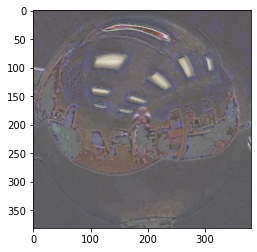

In [34]:
# display difference between naive and weighted 

slog_diff_im = np.log(sweighted_hdr_image)-np.log(snaive_hdr_image)
print('Min ratio = ', np.exp(slog_diff_im).min(), '  Max ratio = ', np.exp(slog_diff_im).max())
plt.figure()
plt.imshow(rescale_images_linear(slog_diff_im))

### LDR merging with camera response function estimation 

Compute HDR after calibrating the photometric reponses to obtain more accurate irradiance estimates from each image

Some suggestions on using <tt>gsolve</tt>:
<ul>
	<li>When providing input to gsolve, don't use all available pixels, otherwise you will likely run out of memory / have very slow run times. To overcome, just randomly sample a set of pixels (1000 or so can suffice), but make sure all pixel locations are the same for each exposure.</li>
	<li>The weighting function w should be implemented using Eq. 4 from the paper (this is the same function that can be used for the previous LDR merging method).</li>
	<li>Try different lambda values for recovering <i>g</i>. Try lambda=1 initially, then solve for <i>g</i> and plot it. It should be smooth and continuously increasing. If lambda is too small, g will be bumpy.</li>
	<li>Refer to Eq. 6 in the paper for using g and combining all of your exposures into a final image. Note that this produces log irradiance values, so make sure to exponentiate the result and save irradiance in linear scale.</li>
</ul>

In [35]:
def make_hdr_estimation(ldr_images: np.ndarray, exposure_times: list, lm)-> (np.ndarray, np.ndarray):
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    Please refer to problem notebook for how to do it.
    
    **IMPORTANT**
    The gsolve operations should be ran with:
        Z: int64 array of shape N x P, where N = number of images, P = number of pixels
        B: float32 array of shape N, log shutter times
        l: lambda; float to control amount of smoothing
        w: function that maps from float intensity to weight  
    The steps to implement:
    1) Create random points to sample (from mirror ball region)
    2) For each exposures, compute g values using samples
    3) Recover HDR image using g values
    

    Args:
        ldr_images(np.ndarray): N x H x W x 3 shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposures(list): list of length N, representing exposures of each images.
            Each exposure should correspond to LDR images' exposure value.
        lm (scalar): the smoothing parameter
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged using
            gsolve
        (np.ndarray): N x H x W x 3 shaped numpy array represending log irradiances
            for each exposures
        (np.ndarray): 3 x 256 shaped numpy array represending g values of each pixel intensities
            at each channels (used for plotting)
    '''
    N, H, W, C = ldr_images.shape
    # sanity check
    assert N == len(exposure_times)
    
    # TO DO: implement HDR estimation using gsolve
    # gsolve(Z, B, l, w) -> g, lE
    
    ldr_images = ldr_images*255
        
    random_width = np.random.randint(W, size=1000)
    random_height = np.random.randint(H, size=1000)

    B = np.log(exposure_times)

    wfunction = lambda z: 128 - np.abs(z - 128)
    ind = np.arange(0, 256)
    wvalue = wfunction(ind)


    hdr_image = np.zeros((H,W,C))
    irradiance = np.zeros((N,H,W,C))

    g_values = np.zeros((C, 256))

    for i in range(0, C):
        Z = ldr_images[:, random_height, random_width, i].astype(np.int64)

        g, le = gsolve(Z, B, lm, wvalue)
        g_values[i] = g

        for h in range(H):
            for w in range(W):
                temp = 0
                zvalue_sum = 0
                for n in range(N):
                    z = int(ldr_images[n, h, w, i])
                    temp += wvalue[z]*(g[z]-B[n])
                    zvalue_sum += wvalue[z]
                    irradiance[n, h, w, i] = g[z] - B[n]
                hdr_image[h, w, i] = np.e**(temp/(zvalue_sum))
    return hdr_image, irradiance, g_values



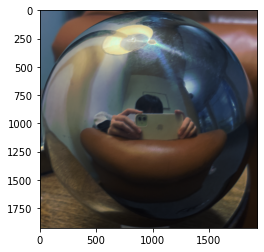

In [44]:
lm = 6000
# get HDR image, log irradiance
calib_hdr_image, calib_log_irradiances, g = make_hdr_estimation(ldr_images, exposure_times, lm)

# write HDR image to directory
write_hdr_image(calib_hdr_image, 'images/outputs/calib_hdr.hdr')

# display HDR image
display_hdr_image(calib_hdr_image)


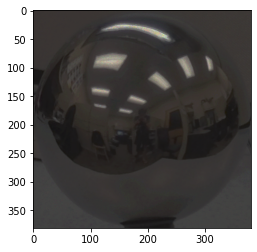

In [45]:
lm = 5
# get HDR image, log irradiance
scalib_hdr_image, scalib_log_irradiances, sg = make_hdr_estimation(sldr_images, sexposure_times, lm)

# write HDR image to directory
write_hdr_image(scalib_hdr_image, 'images/outputs/scalib_hdr.hdr')

# display HDR image
display_hdr_image(scalib_hdr_image)

The following code displays your results. You can copy the resulting images and plots directly into your report where appropriate.

Min ratio =  0.004263070928348364   Max ratio =  5.0126893463232625


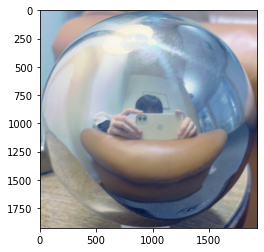

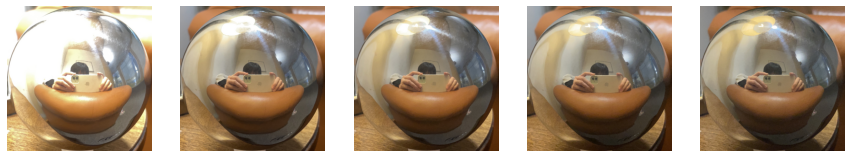

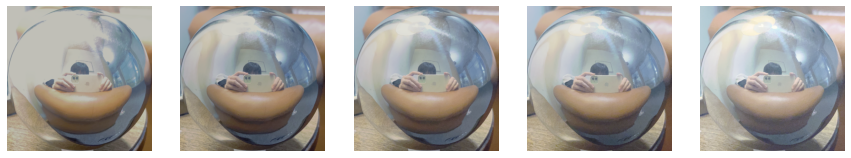

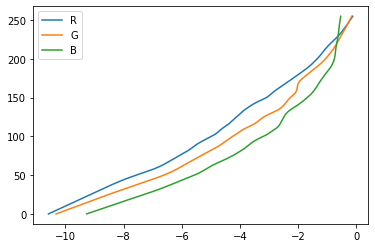

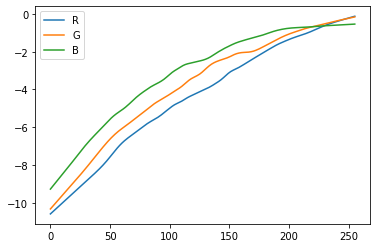

In [46]:
# display difference between calibrated and weighted
log_diff_im = np.log(calib_hdr_image/calib_hdr_image.mean())-np.log(weighted_hdr_image/weighted_hdr_image.mean())
print('Min ratio = ', np.exp(log_diff_im).min(), '  Max ratio = ', np.exp(log_diff_im).max())
plt.figure()
plt.imshow(rescale_images_linear(log_diff_im))

# display original images (code provided in utils.display)
display_images_linear_rescale(ldr_images)

# display log irradiance image (code provided in utils.display)
display_images_linear_rescale(calib_log_irradiances)

# plot g vs intensity, and then plot intensity vs g
N, NG = g.shape
labels = ['R', 'G', 'B']
plt.figure()
for n in range(N):
    plt.plot(g[n], range(NG), label=labels[n])
plt.gca().legend(('R', 'G', 'B'))

plt.figure()
for n in range(N):
    plt.plot(range(NG), g[n], label=labels[n])
plt.gca().legend(('R', 'G', 'B'))

Min ratio =  0.24878108923237913   Max ratio =  3.356624027992375


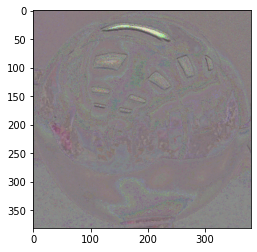

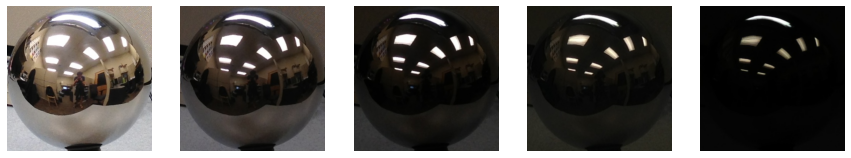

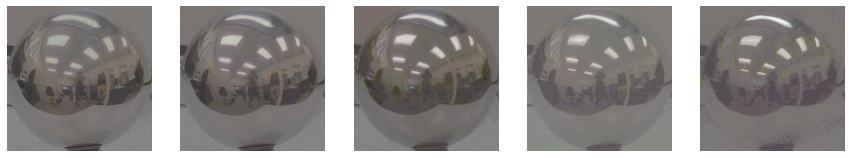

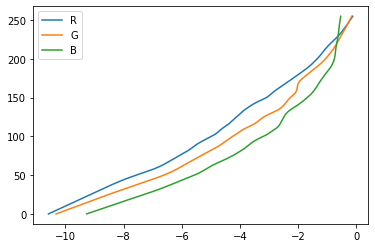

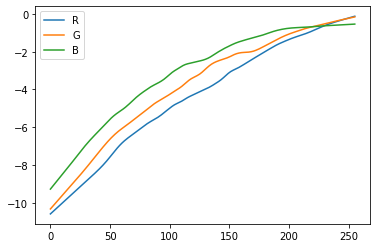

In [47]:
# display difference between calibrated and weighted
slog_diff_im = np.log(scalib_hdr_image/scalib_hdr_image.mean())-np.log(sweighted_hdr_image/sweighted_hdr_image.mean())
print('Min ratio = ', np.exp(slog_diff_im).min(), '  Max ratio = ', np.exp(slog_diff_im).max())
plt.figure()
plt.imshow(rescale_images_linear(slog_diff_im))

# display original images (code provided in utils.display)
display_images_linear_rescale(sldr_images)

# display log irradiance image (code provided in utils.display)
display_images_linear_rescale(scalib_log_irradiances)

# plot g vs intensity, and then plot intensity vs g
N, NG = sg.shape
labels = ['R', 'G', 'B']
plt.figure()
for n in range(N):
    plt.plot(g[n], range(NG), label=labels[n])
plt.gca().legend(('R', 'G', 'B'))

plt.figure()
for n in range(N):
    plt.plot(range(NG), g[n], label=labels[n])
plt.gca().legend(('R', 'G', 'B'))

naive:  	log range =  6.122 	avg RMS error =  0.799
weighted:	log range =  6.387 	avg RMS error =  0.81
calibrated:	log range =  10.696 	avg RMS error =  0.589


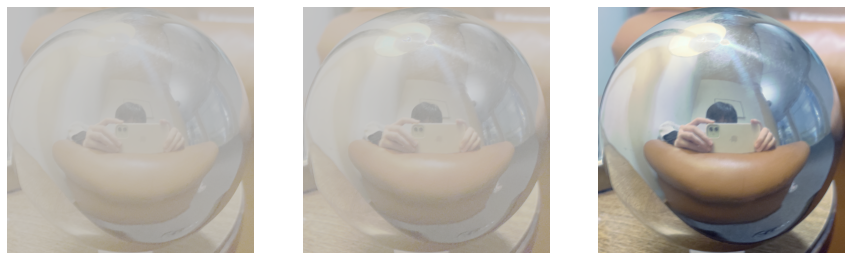

In [48]:
def weighted_log_error(ldr_images, hdr_image, log_irradiances):
  # computes weighted RMS error of log irradiances for each image compared to final log irradiance
  N, H, W, C = ldr_images.shape
  w = 1-abs(ldr_images - 0.5)*2
  err = 0
  for n in np.arange(N):
    err += np.sqrt(np.multiply(w[n], (log_irradiances[n]-np.log(hdr_image))**2).sum()/w[n].sum())/N 
  return err


# compare solutions
err = weighted_log_error(ldr_images, naive_hdr_image, naive_log_irradiances)
print('naive:  \tlog range = ', round(np.log(naive_hdr_image).max() - np.log(naive_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))
err = weighted_log_error(ldr_images, weighted_hdr_image, naive_log_irradiances)
print('weighted:\tlog range = ', round(np.log(weighted_hdr_image).max() - np.log(weighted_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))
err = weighted_log_error(ldr_images, calib_hdr_image, calib_log_irradiances)
print('calibrated:\tlog range = ', round(np.log(calib_hdr_image).max() - np.log(calib_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))

# display log hdr images (code provided in utils.display)
display_images_linear_rescale(np.log(np.stack((naive_hdr_image/naive_hdr_image.mean(), weighted_hdr_image/weighted_hdr_image.mean(), calib_hdr_image/calib_hdr_image.mean()), axis=0)))

naive:  	log range =  6.462 	avg RMS error =  0.324
weighted:	log range =  6.622 	avg RMS error =  0.286
calibrated:	log range =  7.566 	avg RMS error =  0.262


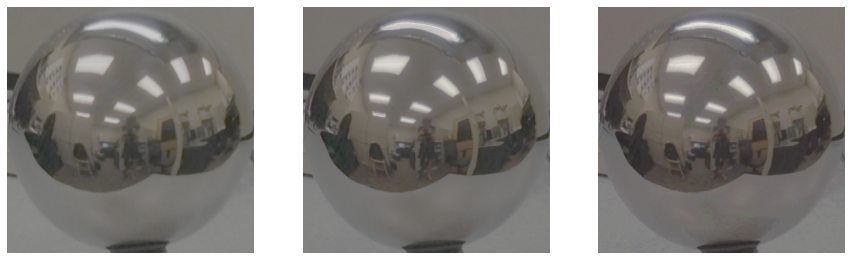

In [49]:
err = weighted_log_error(sldr_images, snaive_hdr_image, snaive_log_irradiances)
print('naive:  \tlog range = ', round(np.log(snaive_hdr_image).max() - np.log(snaive_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))
err = weighted_log_error(sldr_images, sweighted_hdr_image, snaive_log_irradiances)
print('weighted:\tlog range = ', round(np.log(sweighted_hdr_image).max() - np.log(sweighted_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))
err = weighted_log_error(sldr_images, scalib_hdr_image, scalib_log_irradiances)
print('calibrated:\tlog range = ', round(np.log(scalib_hdr_image).max() - np.log(scalib_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))

# display log hdr images (code provided in utils.display)
display_images_linear_rescale(np.log(np.stack((snaive_hdr_image/snaive_hdr_image.mean(), sweighted_hdr_image/sweighted_hdr_image.mean(), scalib_hdr_image/scalib_hdr_image.mean()), axis=0)))

### Additional questions to asnwer

#### For a very bright scene point, will the naive method tend to over-estimate the true brightness, or under-estimate? Why?

- It would often under-estimate the true brightness, because it the true brightness is way beyond the range of the overall picture, which is out of reach for our range. Therefore we would often estimate such true brightness with the maximum of our range, which is under estimating the true brightness.

#### Why does the weighting method result in a higher dynamic range than the naive method?

- Naive method has limitation that under or over exposed pixels results in clipped images. However, for weighting methods, we are weighting each pixels such that these under-over exposed pixels will be converted to the desirable range, which allows us to obtain a wider range of pixel values without clipping images like the naitve methods. 

#### Why does the calibration method result in a higher dynamic range than the weighting method? and why does the calibration method result in higher consistency, compared to the weighting method?

- This is because of the non-linearity of intensity with clipping and camera response function. The weighting method is merely estimating the radiance map by computing the log of the sum, which is not accurate and limited. In contrast, the calibration method computes the radiance map using different exposure times.  

## Panoramic transformations 

Compute the equirectangular image from the mirrorball image

In [59]:
def panoramic_transform(hdr_image):
    '''
    Given HDR mirror ball image, 
    
    Enxpects mirror ball image to have center of the ball at center of the image, and
    width and height of the image to be equal.
    
    Steps to implement:
    1) Compute N image of normal vectors of mirror ball
    2) Compute R image of reflection vectors of mirror ball
    3) Map reflection vectors into spherical coordinates
    4) Interpolate spherical coordinate values into equirectangular grid.
    
    Steps 3 and 4 are implemented for nyou with get_equirectangular_image

    '''
    H, W, C = hdr_image.shape
    assert H == W
    assert C == 3

    # TO DO: compute N and R
    nx, ny = np.meshgrid(range(W), range(H))
    nx = (nx-W/2)/(W/2)
    ny = (ny-H/2)/(H/2)
    nz = np.sqrt(1-np.clip(nx**2 + ny**2, a_min=0, a_max=1))
    
    # Normal vector
    N = np.zeros((H,W,3))
    N[:,:,0] = nx
    N[:,:,1] = ny
    N[:,:,2] = nz
    
    # V = (0, 0, -1) for all location within the sphere
    V = np.zeros((H,W,C))
    V[:,:,2] = 1

    R = np.zeros((H,W,3))
    for c in range(C):
        R[:,:,c] = -1 * V[:,:,c]+ 2 * nz * N[:,:,c]


    plt.figure()
    plt.imshow(N)
    plt.figure()
    plt.imshow(R)
    plt.show()
    equirectangular_image = get_equirectangular_image(R, hdr_image) 
    return equirectangular_image.astype(np.float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


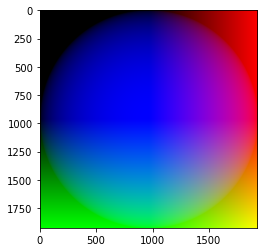

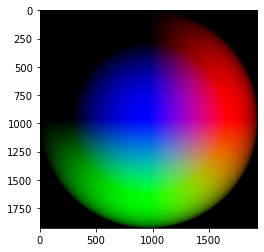

<Figure size 1080x1080 with 0 Axes>

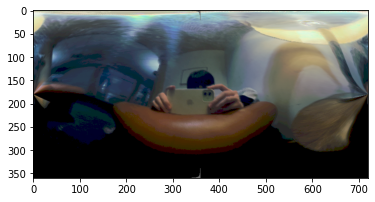

In [51]:
hdr_mirrorball_image = read_hdr_image('images/outputs/calib_hdr.hdr')
eq_image = panoramic_transform(hdr_mirrorball_image)

write_hdr_image(eq_image, 'images/outputs/equirectangular.hdr')

plt.figure(figsize=(15,15))
display_hdr_image(eq_image)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


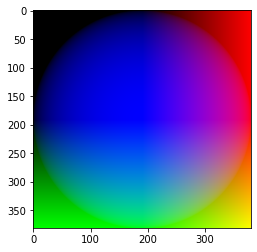

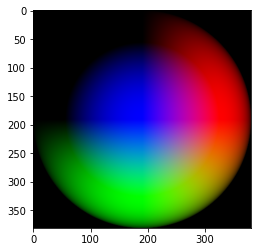

<Figure size 1080x1080 with 0 Axes>

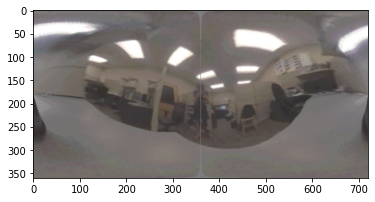

In [60]:
shdr_mirrorball_image = read_hdr_image('images/outputs/scalib_hdr.hdr')
seq_image = panoramic_transform(shdr_mirrorball_image)

write_hdr_image(seq_image, 'images/outputs/sequirectangular.hdr')

plt.figure(figsize=(15,15))
display_hdr_image(seq_image)

---

## Rendering synthetic objects into photographs 

Use Blender to render the scene with and with objects and obtain the mask image.  The code below should then load the images and create the final composite.

In [71]:
# Read the images that you produced using Blender.  Modify names as needed.
O = read_image('render/object.png')
E = read_image('render/mask.png')
M = read_image('mask.png')
M = M > 0.5
I = background_image
I = cv2.resize(I, (M.shape[1], M.shape[0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


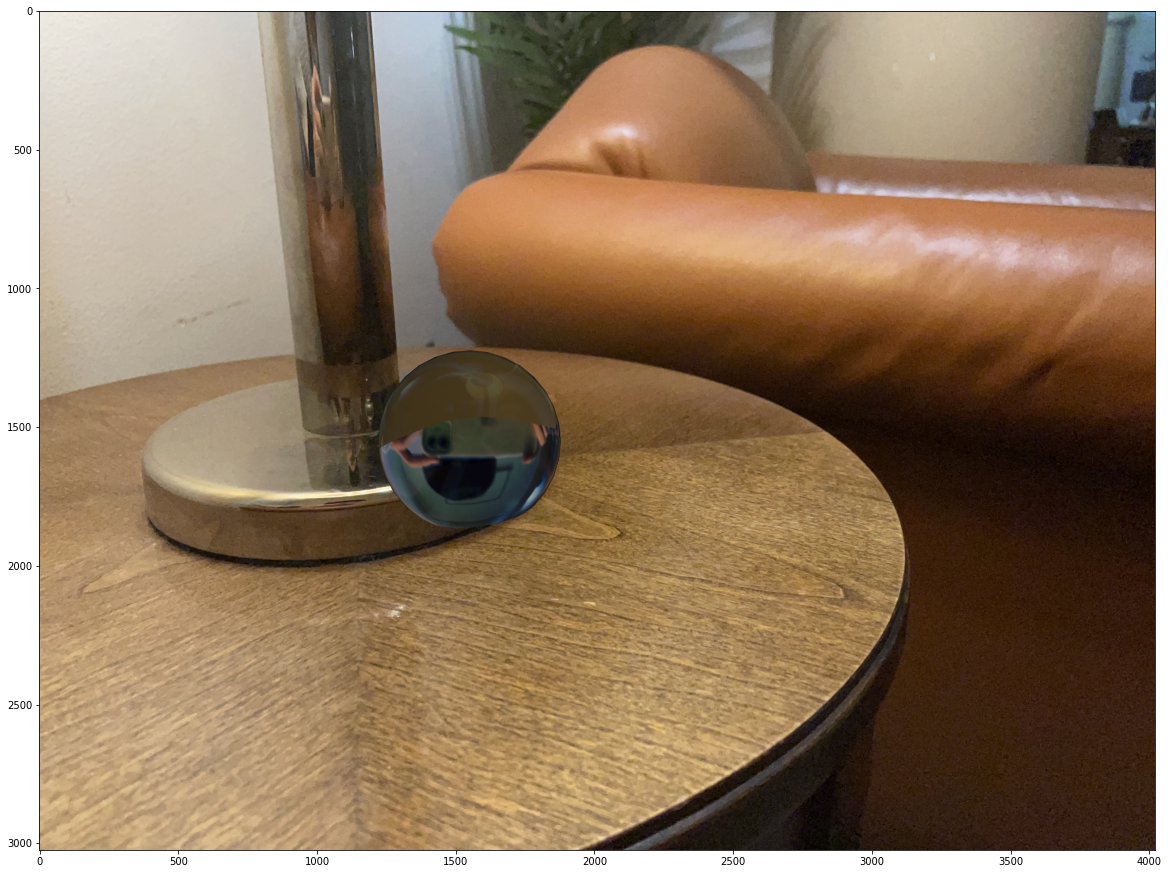

In [73]:
# TO DO: compute final composite
result = (M*O + (1-M)*I + (1-M)*(O-E)*0.1)


plt.figure(figsize=(20,20))
plt.imshow(result)
plt.show()

write_image(result, 'images/outputs/final_composite.png')

---